In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_pickle("../../data/updated_molecules.pth")

In [3]:
BATCHSIZE = 128

In [4]:
scalar = MinMaxScaler()
data = df["fingerprint_circular"]
target = df["Egc"]

#data = data.values.reshape(-1, 1)  # Reshape data

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=123)

# Scaling target variable
target_train = scalar.fit_transform(target_train.values.reshape(-1, 1))
target_test = scalar.transform(target_test.values.reshape(-1, 1))

# Creating tensors from data

#Training Data
data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= BATCHSIZE, shuffle= True)

#Testing Data

data_test_tensor = torch.tensor(data_test.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = BATCHSIZE, shuffle= False)

/tmp/ipykernel_2087273/1401387681.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)


In [5]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2048, 1888),
                nn.Dropout(0.296708814),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1888, 416),
                nn.Dropout(0.103316943),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(416, 1632),
                nn.Dropout(0.178598433),
                nn.PReLU()
            ),
            
            nn.Linear(1632, 1)
        ])
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

Epoch [1/227], Loss: 0.0017078152474984593
Epoch [2/227], Loss: 0.0005632392448636605
Epoch [3/227], Loss: 0.00037496739116432725
Epoch [4/227], Loss: 0.00027735970538590244
Epoch [5/227], Loss: 0.00023192579653094584
Epoch [6/227], Loss: 0.00020235848285700083
Epoch [7/227], Loss: 0.00018209259785167565
Epoch [8/227], Loss: 0.00016745368619134726
Epoch [9/227], Loss: 0.00015527454689491827
Epoch [10/227], Loss: 0.0001425054964279276
Epoch [11/227], Loss: 0.00012935326323200032
Epoch [12/227], Loss: 0.0001264984365962067
Epoch [13/227], Loss: 0.00011882847390147639
Epoch [14/227], Loss: 0.00011373049886334625
Epoch [15/227], Loss: 0.00010601769374618329
Epoch [16/227], Loss: 9.851817558054437e-05
Epoch [17/227], Loss: 9.641064888277312e-05
Epoch [18/227], Loss: 9.056460372126761e-05
Epoch [19/227], Loss: 8.860954954563229e-05
Epoch [20/227], Loss: 8.179881407206841e-05
Epoch [21/227], Loss: 8.035840740389498e-05
Epoch [22/227], Loss: 7.882818749422903e-05
Epoch [23/227], Loss: 7.614319

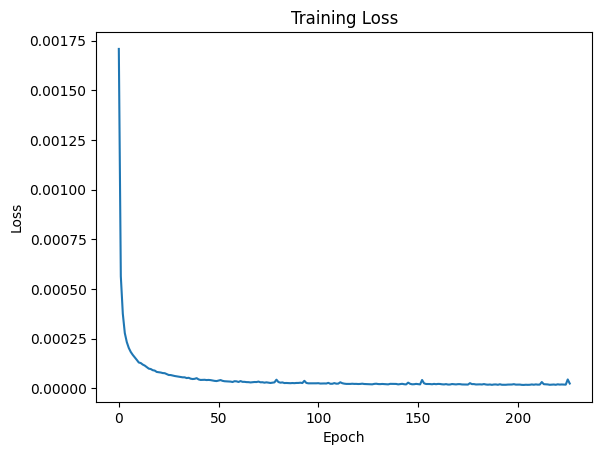

In [6]:
net = MTmodel()


net = MTmodel()
net = net.to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr =  0.000364567)


EPOCHS = 227
losses = []
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  for batch_idx,(data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.view(-1).to(DEVICE)
    optimizer.zero_grad()
    output = net(data)
    loss = F.mse_loss(output.view(-1), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / batch_idx
  losses.append(epoch_loss)

  # Print epoch loss
  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


mse: 9.431650647839329e-05, rmse: 0.009711668573339665, r2_score: 0.9557281545596634


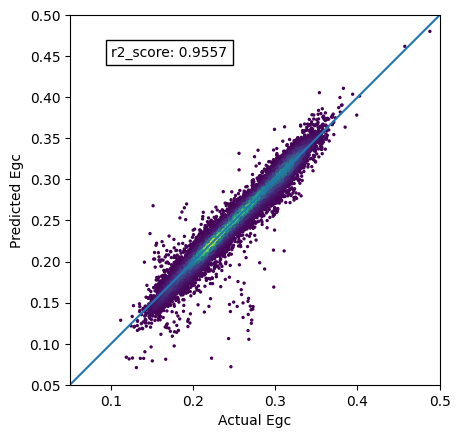

In [7]:
# Plot predictions vs. true values
from scipy.stats import gaussian_kde


@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model.to(DEVICE)
    

    for batch_idx,(data, target) in enumerate(data_loader):

        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)
                                     
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred).to(DEVICE)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu).to(DEVICE)
        

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)

    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]
    
    #actual_array = np.squeeze(np.array(actual))
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    
    
    # Plot actuals vs predictions
    
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(pred_list, act_list, c=z, s=2)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0.1
    text_y = 0.45
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=10, bbox=dict(facecolor='white', alpha=1))
    plt.show()


graphPredictions(net, test_loader, 0.05, 0.5)